<a href="https://colab.research.google.com/github/RNF24/Hate-Speech-and-Offensive-Language-Detection/blob/main/Hate_Speech_and_Offensive_Language_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Prepare the library

In [1]:
!pip install opendatasets --quiet

In [20]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, Dropout, SimpleRNN
import tensorflow as tf

from tensorflow.keras.utils import to_categorical

import opendatasets as od
import numpy as np

#Download the dataset from Kaagle

In [3]:
od.download("https://www.kaggle.com/datasets/thedevastator/hate-speech-and-offensive-language-detection/data")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: rahmanurfitriyani
Your Kaggle Key: ··········


100%|██████████| 963k/963k [00:00<00:00, 63.2MB/s]

#Show the Dataset

In [4]:
data = pd.read_csv("/content/hate-speech-and-offensive-language-detection/train.csv")

data.head()

,count,hate_speech_count,offensive_language_count,neither_count,class,tweet
0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [5]:
print(f"num of tweets: {data.shape}")

num of tweets: (24783, 6)


In [6]:
data['class'].value_counts()

1    19190
2     4163
0     1430
Name: class, dtype: int64

Note: 0 - hate speech; 1 - offensive language; 2 - neither

#Data cleaning
1) check if there's any duplicate

2) check if there's any null

3) clean the data

In [7]:
data.duplicated().sum()

0

In [8]:
data.isna().sum()

count                       0
hate_speech_count           0
offensive_language_count    0
neither_count               0
class                       0
tweet                       0
dtype: int64

In [9]:
#Remove URL
data["tweet"] = data["tweet"].str.replace('https?://\S+\.?\S+', '')
data["tweet"]

<ipython-input-9-ffd86e684668>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  data["tweet"] = data["tweet"].str.replace('https?://\S+\.?\S+', '')


0        !!! RT @mayasolovely: As a woman you shouldn't...
1        !!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2        !!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3        !!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4        !!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...
                               ...                        
24778    you's a muthaf***in lie &#8220;@LifeAsKing: @2...
24779    you've gone and broke the wrong heart baby, an...
24780    young buck wanna eat!!.. dat nigguh like I ain...
24781                youu got wild bitches tellin you lies
24782    ~~Ruffled | Ntac Eileen Dahlia - Beautiful col...
Name: tweet, Length: 24783, dtype: object

In [10]:
#Remove punctional
data['tweet'] = data['tweet'].str.replace('[^a-zA-Z0-9\s]', '')
data['tweet']

<ipython-input-10-45d970b5bebd>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  data['tweet'] = data['tweet'].str.replace('[^a-zA-Z0-9\s]', '')


0         RT mayasolovely As a woman you shouldnt compl...
1         RT mleew17 boy dats coldtyga dwn bad for cuff...
2         RT UrKindOfBrand Dawg RT 80sbaby4life You eve...
3           RT CGAnderson vivabased she look like a tranny
4         RT ShenikaRoberts The shit you hear about me ...
                               ...                        
24778    yous a muthafin lie 8220LifeAsKing 20Pearls co...
24779    youve gone and broke the wrong heart baby and ...
24780    young buck wanna eat dat nigguh like I aint fu...
24781                youu got wild bitches tellin you lies
24782    Ruffled  Ntac Eileen Dahlia  Beautiful color c...
Name: tweet, Length: 24783, dtype: object

In [11]:
#Remove username
data["tweet"] = data["tweet"].str.replace('@\w+', '')
data["tweet"]

<ipython-input-11-c24cc91af43e>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  data["tweet"] = data["tweet"].str.replace('@\w+', '')


0         RT mayasolovely As a woman you shouldnt compl...
1         RT mleew17 boy dats coldtyga dwn bad for cuff...
2         RT UrKindOfBrand Dawg RT 80sbaby4life You eve...
3           RT CGAnderson vivabased she look like a tranny
4         RT ShenikaRoberts The shit you hear about me ...
                               ...                        
24778    yous a muthafin lie 8220LifeAsKing 20Pearls co...
24779    youve gone and broke the wrong heart baby and ...
24780    young buck wanna eat dat nigguh like I aint fu...
24781                youu got wild bitches tellin you lies
24782    Ruffled  Ntac Eileen Dahlia  Beautiful color c...
Name: tweet, Length: 24783, dtype: object

In [12]:
#Remove RT and : (colons)
def remove_RT_and_colons(text):
    text = text.replace("RT", "").replace("rt", "").replace("Rt", "").replace("rT", "").replace(":", "")
    return text

data['tweet'] = data['tweet'].apply(remove_RT_and_colons)
data['tweet']

0          mayasolovely As a woman you shouldnt complai...
1          mleew17 boy dats coldtyga dwn bad for cuffin...
2          UrKindOfBrand Dawg  80sbaby4life You ever fu...
3              CGAnderson vivabased she look like a tranny
4          ShenikaRobes The shit you hear about me migh...
                               ...                        
24778    yous a muthafin lie 8220LifeAsKing 20Pearls co...
24779    youve gone and broke the wrong hea baby and dr...
24780    young buck wanna eat dat nigguh like I aint fu...
24781                youu got wild bitches tellin you lies
24782    Ruffled  Ntac Eileen Dahlia  Beautiful color c...
Name: tweet, Length: 24783, dtype: object

In [13]:
# remove stopwords
nltk.download('stopwords')
print(stopwords.words('english'))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [14]:
STOPWORDS = set(stopwords.words('english'))

def remove_stopwords(text):
    words = text.split()
    filtered_words = [word for word in words if word.lower() not in STOPWORDS]
    return ' '.join(filtered_words)

data["Text_stop"] = data["tweet"].apply(remove_stopwords)
data

,count,hate_speech_count,offensive_language_count,neither_count,class,tweet,Text_stop
0,3,0,0,3,2,mayasolovely As a woman you shouldnt complai...,mayasolovely woman shouldnt complain cleaning ...
1,3,0,3,0,1,mleew17 boy dats coldtyga dwn bad for cuffin...,mleew17 boy dats coldtyga dwn bad cuffin dat h...
2,3,0,3,0,1,UrKindOfBrand Dawg 80sbaby4life You ever fu...,UrKindOfBrand Dawg 80sbaby4life ever fuck bitc...
3,3,0,2,1,1,CGAnderson vivabased she look like a tranny,CGAnderson vivabased look like tranny
4,6,0,6,0,1,ShenikaRobes The shit you hear about me migh...,ShenikaRobes shit hear might true might faker ...
...,...,...,...,...,...,...,...
24778,3,0,2,1,1,yous a muthafin lie 8220LifeAsKing 20Pearls co...,yous muthafin lie 8220LifeAsKing 20Pearls core...
24779,3,0,1,2,2,youve gone and broke the wrong hea baby and dr...,youve gone broke wrong hea baby drove redneck ...
24780,3,0,3,0,1,young buck wanna eat dat nigguh like I aint fu...,young buck wanna eat dat nigguh like aint fuck...
24781,6,0,6,0,1,youu got wild bitches tellin you lies,youu got wild bitches tellin lies


#Split

In [15]:
#Extract the text and labels
tweet = list(data['tweet'])
labels = list(data['class'])

In [16]:
training_size = 20000

# Split the sentences
training_sentences = tweet[0:training_size]
testing_sentences = tweet[training_size:]

# Split the labels
training_labels = labels[0:training_size]
testing_labels = labels[training_size:]

In [17]:
vocab_size = 10000
max_length = 120
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"

# Initialize the Tokenizer class
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)

# Generate the word index dictionary
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index

# Generate and pad the training sequences
training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

# Generate and pad the testing sequences
testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

# Convert the labels lists into numpy arrays
training_labels = np.array(training_labels)
testing_labels = np.array(testing_labels)

In [18]:
# Convert integer labels to one-hot encoded vectors
one_hot_labels_train = to_categorical(training_labels, num_classes=3)
one_hot_labels_test = to_categorical(testing_labels, num_classes=3)

#Train the Model

In [31]:
# Model Definition with LSTM
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, 128, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])

# Print the model summary
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 120, 128)          1280000   
                                                                 
 bidirectional_4 (Bidirecti  (None, 64)                41216     
 onal)                                                           
                                                                 
 dense_10 (Dense)            (None, 32)                2080      
                                                                 
 dense_11 (Dense)            (None, 64)                2112      
                                                                 
 dense_12 (Dense)            (None, 8)                 520       
                                                                 
 dense_13 (Dense)            (None, 3)                 27        
                                                      

In [22]:
# Compute precision, recall, and F1 score using TensorFlow metrics
precision = tf.keras.metrics.Precision()
recall = tf.keras.metrics.Recall()

In [32]:
# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy',precision, recall])

In [33]:
# Train the model
history = model.fit(training_padded, one_hot_labels_train, epochs=15, validation_data=(testing_padded, one_hot_labels_test))

Epoch 1/15
625/625 [==============================] - 96s 143ms/step - loss: 0.4447 - accuracy: 0.8418 - precision: 0.8747 - recall: 0.8039 - val_loss: 0.3012 - val_accuracy: 0.9042 - val_precision: 0.9197 - val_recall: 0.8881
Epoch 2/15
625/625 [==============================] - 86s 138ms/step - loss: 0.2642 - accuracy: 0.9089 - precision: 0.9204 - recall: 0.8963 - val_loss: 0.2805 - val_accuracy: 0.8959 - val_precision: 0.9120 - val_recall: 0.8861
Epoch 3/15
625/625 [==============================] - 85s 136ms/step - loss: 0.1711 - accuracy: 0.9378 - precision: 0.9428 - recall: 0.9337 - val_loss: 0.2951 - val_accuracy: 0.9007 - val_precision: 0.9069 - val_recall: 0.8965
Epoch 4/15
625/625 [==============================] - 85s 136ms/step - loss: 0.1163 - accuracy: 0.9592 - precision: 0.9616 - recall: 0.9575 - val_loss: 0.3540 - val_accuracy: 0.9007 - val_precision: 0.9023 - val_recall: 0.8980
Epoch 5/15
625/625 [==============================] - 87s 139ms/step - loss: 0.0822 - accura

#Plot the result

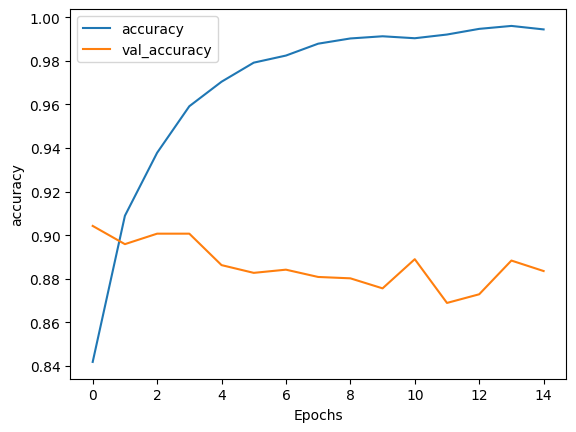

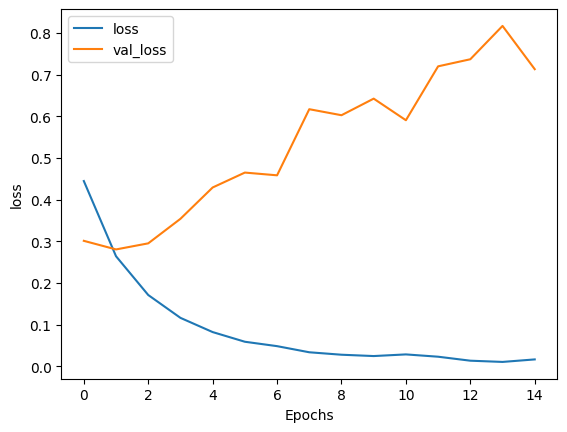

In [34]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

# Plot the accuracy and loss history
plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')